In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wE_M0eg0g3y0dyEDXamutswj3WxLY14oysvs2bo2gN0w8QNO-aZ3Y0
Mounted at /content/drive


## 데이터셋 이해하기 

### dataset overview

In [4]:
os.chdir('/content/drive/My Drive/문서/수업자료/SE/comento_data_analysis/data')
os.getcwd()

'/content/drive/My Drive/문서/수업자료/SE/comento_data_analysis/data'

In [5]:
raw_repair = pd.read_csv('4th_data.csv')
raw_repair[:20]

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
0,1,FirstContact,Dian,complete,1970-01-02 08:08,Phone,NaN,NaN,NaN,NaN,NaN,NaN
1,1,MakeTicket,Dian,start,1970-01-02 08:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,MakeTicket,Dian,complete,1970-01-02 08:11,NaN,E,1340.0,NaN,NaN,NaN,NaN
3,1,ArrangeSurvey,Dian,start,1970-01-02 08:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,ArrangeSurvey,Dian,complete,1970-01-02 08:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,InformClientSurvey,System,complete,1970-01-02 08:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,Survey,Cindy,start,1970-01-11 21:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Survey,Cindy,complete,1970-01-11 21:56,NaN,NaN,NaN,True,240.0,1.0,NaN
8,1,InternRepair,John,start,1970-01-17 04:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,InternRepair,John,complete,1970-01-17 08:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
raw_repair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13262 entries, 0 to 13261
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   caseID               13262 non-null  int64  
 1   taskID               13262 non-null  object 
 2   originator           13262 non-null  object 
 3   eventtype            13262 non-null  object 
 4   timestamp            13262 non-null  object 
 5   contact              1000 non-null   object 
 6   RepairType           927 non-null    object 
 7   objectKey            927 non-null    float64
 8   RepairInternally     927 non-null    object 
 9   EstimatedRepairTime  927 non-null    float64
 10  RepairCode           927 non-null    float64
 11  RepairOK             1854 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.2+ MB


In [7]:
cols = raw_repair.columns.tolist()
cols.remove('caseID')
cols.remove('objectKey')
for col in cols:
  print(f'======Unique vals of {col}======')
  print(raw_repair[col].value_counts(dropna=False).sort_index())

======Unique vals of taskID======
ArrangeSurvey             1854
ExternRepair               132
FirstContact              1000
ImmediateRepair            766
InformClientSurvey         927
InformClientWrongPlace      73
InternRepair              1094
MakeTicket                1854
ReadyInformClient          927
RepairReady                927
SendTicketToFinAdmin       927
Survey                    1854
TicketReady                927
Name: taskID, dtype: int64
======Unique vals of originator======
Anne        866
Barbara     428
Ben         120
Cindy       388
Dian       2246
DoIt         66
Edd         372
Eric         98
FixIt        66
Jacky       438
John        396
Lex         112
Monica     2535
Nick        108
Paul        388
System     4635
Name: originator, dtype: int64
======Unique vals of eventtype======
complete    9419
start       3843
Name: eventtype, dtype: int64
======Unique vals of timestamp======
1970-01-01 09:13    2
1970-01-01 09:15    2
1970-01-01 09:18    5
1970-01

### 각 열에 대한 가설
*   taskID별로 originator들이 정해져 있다. (일대다)
*   eventtype 중 maketicket, ArrangeSurvey ,Survey, Intern/ExternRepair 과업만 start와 complete이 존재한다.
*   contact는 고객에게 FirstContact시 연결 수단 
*   RepairType은 MakeTicket 과정에서 수리 유형을 적어놓은 것
*   MakeTicket 과정에서 objectKey는 수리가 필요한 부품 번호나 고객 번호
*   RepairInternally는 Survey 과정에서 자체 수리가 가능한지 여부를 적어놓은 것
*   Survey 과정에서 RepairInternally,EstimatedRepairTime,RepairCode 작성
*   RepairReady가 되면 RepairOK가 True로 작성되고 , ReadyInformClient	과정에서 고객에게 RepairOK==True를 알림







### 가설 검증

In [8]:
taskIds = raw_repair['taskID'].unique()
originators = raw_repair['originator'].unique()

In [9]:
print('<Checking for task -> originator relationship>')
for task in taskIds:
  handlers = raw_repair.loc[raw_repair['taskID']==task,'originator'].unique()
  print(f'{task} was handled by {handlers}')

<Checking for task -> originator relationship>
FirstContact was handled by ['Dian' 'Monica']
MakeTicket was handled by ['Dian' 'Monica']
ArrangeSurvey was handled by ['Dian' 'Monica']
InformClientSurvey was handled by ['System']
Survey was handled by ['Cindy' 'Anne' 'Paul' 'Jacky' 'Edd' 'Barbara' 'Eric' 'Nick' 'John' 'Ben'
 'Lex']
InternRepair was handled by ['John' 'Paul' 'Cindy' 'Anne' 'Jacky' 'Edd' 'Nick' 'Eric' 'Lex' 'Barbara'
 'Ben']
RepairReady was handled by ['System']
SendTicketToFinAdmin was handled by ['System']
ReadyInformClient was handled by ['System']
TicketReady was handled by ['System']
ImmediateRepair was handled by ['Anne' 'Jacky' 'Barbara' 'Nick' 'Eric' 'Ben' 'Lex']
ExternRepair was handled by ['DoIt' 'FixIt']
InformClientWrongPlace was handled by ['Monica' 'Dian']


In [10]:
print('<Checking for originator -> task relationship>')
for originator in originators:
  task = raw_repair.loc[raw_repair['originator']==originator,'taskID'].unique()
  print(f'{originator} handled {task}')

<Checking for originator -> task relationship>
Dian handled ['FirstContact' 'MakeTicket' 'ArrangeSurvey' 'InformClientWrongPlace']
System handled ['InformClientSurvey' 'RepairReady' 'SendTicketToFinAdmin'
 'ReadyInformClient' 'TicketReady']
Cindy handled ['Survey' 'InternRepair']
John handled ['InternRepair' 'Survey']
Anne handled ['Survey' 'ImmediateRepair' 'InternRepair']
DoIt handled ['ExternRepair']
Paul handled ['Survey' 'InternRepair']
Monica handled ['FirstContact' 'MakeTicket' 'ArrangeSurvey' 'InformClientWrongPlace']
Jacky handled ['Survey' 'ImmediateRepair' 'InternRepair']
Edd handled ['Survey' 'InternRepair']
Barbara handled ['Survey' 'ImmediateRepair' 'InternRepair']
Eric handled ['Survey' 'ImmediateRepair' 'InternRepair']
FixIt handled ['ExternRepair']
Nick handled ['Survey' 'ImmediateRepair' 'InternRepair']
Lex handled ['InternRepair' 'Survey' 'ImmediateRepair']
Ben handled ['Survey' 'ImmediateRepair' 'InternRepair']


* task와 originator는 다대다 관계이다.
* 접수 및 고객 응대, 점검 및 즉시/내부 수리, 외부 수리, 시스템 총 4가지 파트로 나뉜다.
* Cindy 와 John, Paul, Edd는 ImmediateRepair를 하지 않았지만 실제로도 담당하지 않는지는 확실하지 않다. ImmediateRepair가 적절하지 않은 고객만 상대했을 수도 있다.

In [11]:
taskComplete = raw_repair.loc[raw_repair['eventtype']=='complete','taskID'].unique()
tasksWStart = raw_repair.loc[raw_repair['eventtype']=='start','taskID'].unique()
print(f'Tasks with start: {tasksWStart}')
for taskWStart in tasksWStart:
  if taskWStart not in taskComplete:
    print(f'{taskWStart} does not have complete')

Tasks with start: ['MakeTicket' 'ArrangeSurvey' 'Survey' 'InternRepair' 'ImmediateRepair'
 'ExternRepair']
ExternRepair does not have complete


* 'MakeTicket' 'ArrangeSurvey' 'Survey' 'InternRepair' 'ImmediateRepair'은 start와 complete이 존재하나 ExternRepair는 start만 있고 complete가 없다. 




In [12]:
t_repair = raw_repair.copy()
t_repair.loc[:,'timestamp'] = pd.to_datetime(raw_repair['timestamp'],format="%Y-%m-%d %H:%M")

In [13]:
t_repair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13262 entries, 0 to 13261
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   caseID               13262 non-null  int64         
 1   taskID               13262 non-null  object        
 2   originator           13262 non-null  object        
 3   eventtype            13262 non-null  object        
 4   timestamp            13262 non-null  datetime64[ns]
 5   contact              1000 non-null   object        
 6   RepairType           927 non-null    object        
 7   objectKey            927 non-null    float64       
 8   RepairInternally     927 non-null    object        
 9   EstimatedRepairTime  927 non-null    float64       
 10  RepairCode           927 non-null    float64       
 11  RepairOK             1854 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 1.2+ MB


TODO: time(repair complete ) == time(repairReady) ??


In [14]:

#iRepairComplete = raw_repair.loc[(raw_repair['taskID'].isin(iRepairs)) ,['caseID','taskID','timestamp']] #& (raw_repair['eventtype']=='complete')
#lastRepair1 = (raw_repair['taskID'].isin(('InternRepair','ImmediateRepair'))) & (raw_repair['eventtype']=='complete')
#lastRepair2 = raw_repair['taskID']=="ExternRepair"
repairFil = t_repair['taskID'].isin(['ExternRepair','InternRepair','ImmediateRepair'])
#iRepairComplete = raw_repair.loc[(raw_repair['taskID'].isin(('InternRepair','ImmediateRepair'))) & (raw_repair['eventtype']=='complete') ,:]
#iRepairComplete = raw_repair.loc[lastRepair1 | lastRepair2,:]
iRepairComplete = raw_repair.loc[repairFil,:]
#iRepairComplete.loc[:,'timestamp'] = pd.to_datetime(iRepairComplete['timestamp'],format="%Y-%m-%d %H:%M")
RepairCompleteT = iRepairComplete.groupby('caseID')['timestamp'].agg(['max']).reset_index()
RepairCompleteT.loc[:,'max'] = pd.to_datetime(RepairCompleteT['max'],format="%Y-%m-%d %H:%M")
RepairCompleteT.info()
RepairCompleteT.reset_index(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   caseID  927 non-null    int64         
 1   max     927 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 14.6 KB


In [15]:
repairReadyT = t_repair.loc[(t_repair['taskID']=="RepairReady") ,['caseID','eventtype','taskID','timestamp']]
repairReadyT.reset_index(inplace=True)
repairReadyT

,index,caseID,eventtype,taskID,timestamp
0,10,1,complete,RepairReady,1970-01-17 08:12:00
1,25,2,complete,RepairReady,1970-01-12 08:57:00
2,39,3,complete,RepairReady,1970-01-06 23:30:00
3,53,4,complete,RepairReady,1970-01-04 19:42:00
4,67,5,complete,RepairReady,1970-01-10 01:10:00
...,...,...,...,...,...
922,13203,996,complete,RepairReady,1970-01-02 12:29:00
923,13217,997,complete,RepairReady,1970-01-14 20:19:00
924,13231,998,complete,RepairReady,1970-01-19 10:34:00
925,13244,999,complete,RepairReady,1970-01-07 12:23:00


In [16]:
tDiff = (repairReadyT['timestamp'] - RepairCompleteT['max']).astype('timedelta64[m]') != 0
casesTDiff = repairReadyT.loc[tDiff,'caseID'].tolist()
len(casesTDiff)

132

In [17]:
extFilter = (raw_repair['caseID'].isin(casesTDiff)) & (raw_repair['taskID']=='ExternRepair')
extFilter.value_counts()

False    13130
True       132
dtype: int64

* 수리가 끝나는 즉시(complete) RepairReady 상태가 된다.
* ExternRepair의 경우 complete timestamp가 입력되지 않았으므로 수리 완료시간을 RepairReady로 전환되는 시간으로 갈음할 수 있다. 



In [18]:
raw_repair.loc[~raw_repair['contact'].isna(),'taskID'].unique()

array(['FirstContact'], dtype=object)

* contact는 고객에게 FirstContact시 연결 수단

In [19]:
raw_repair.loc[~raw_repair['RepairType'].isna(),'taskID'].unique()

array(['MakeTicket'], dtype=object)

* RepairType은 MakeTicket 과정에서 수리 유형을 적어놓은 것

In [20]:
raw_repair.loc[~raw_repair['objectKey'].isna(),'taskID'].unique()

array(['MakeTicket'], dtype=object)

In [21]:
raw_repair['objectKey'].value_counts()

8615.0    3
5997.0    3
6784.0    2
3271.0    2
6776.0    2
         ..
4563.0    1
7263.0    1
2931.0    1
2305.0    1
20.0      1
Name: objectKey, Length: 890, dtype: int64

*  MakeTicket 과정에서 objectKey는 수리 관련 일련번호(예: 고장 부위 등)


In [22]:
for repairInfo in ('RepairInternally','EstimatedRepairTime','RepairCode'):
  print(f'{repairInfo} at task ')
  print(raw_repair.loc[~raw_repair[repairInfo].isna(),'taskID'].unique())

RepairInternally at task 
['Survey']
EstimatedRepairTime at task 
['Survey']
RepairCode at task 
['Survey']


* Survey 과정에서 RepairInternally,EstimatedRepairTime,RepairCode 작성

In [23]:
# TODO: taksID==InternRepair exists if RepairInternally ==True?
RIcases = raw_repair.loc[raw_repair['RepairInternally']==True,'caseID'].tolist()
raw_repair.loc[(raw_repair['caseID'].isin(RIcases)) & (raw_repair['taskID'].isin(['ImmediateRepair','ExternRepair'])),'taskID']

22       ImmediateRepair
23       ImmediateRepair
24          ExternRepair
51       ImmediateRepair
52       ImmediateRepair
              ...       
13103    ImmediateRepair
13104    ImmediateRepair
13105       ExternRepair
13132    ImmediateRepair
13133    ImmediateRepair
Name: taskID, Length: 839, dtype: object

In [24]:
raw_repair.iloc[20:30]

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
20,2,Survey,Anne,start,1970-01-12 04:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2,Survey,Anne,complete,1970-01-12 04:57,NaN,NaN,NaN,True,120.0,1.0,NaN
22,2,ImmediateRepair,Anne,start,1970-01-12 04:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2,ImmediateRepair,Anne,complete,1970-01-12 06:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2,ExternRepair,DoIt,start,1970-01-12 06:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2,RepairReady,System,complete,1970-01-12 08:57,NaN,NaN,NaN,NaN,NaN,NaN,True
26,2,ReadyInformClient,System,complete,1970-01-12 11:17,NaN,NaN,NaN,NaN,NaN,NaN,True
27,2,SendTicketToFinAdmin,System,complete,1970-01-12 15:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2,TicketReady,System,complete,1970-01-12 15:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,3,FirstContact,Dian,complete,1970-01-03 01:03,Phone,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
nRIcases = raw_repair.loc[raw_repair['RepairInternally']==False,'caseID'].tolist()
raw_repair.loc[(raw_repair['caseID'].isin(nRIcases)) & (raw_repair['taskID']=='InternRepair'),'taskID']

Series([], Name: taskID, dtype: object)

In [26]:
raw_repair.loc[(raw_repair['caseID'].isin(nRIcases)) & (raw_repair['taskID'].isin(['ExternRepair','ImmediateRepair'])),'taskID'].unique()

array(['ExternRepair'], dtype=object)

* Survey 과정에서 RepairInternally는 내부 수리를 해야할지 여부를 적어놓은 것
* 그러나 후속 조치와 상응하지 않는 경우가 존재 
  * RepairInternally==True 이지만 ImmediateRepair나 ExternRepair가 이루어지는 경우 -> ImmediateRepair가 InternalRepair
  * ImmediateRepair와 InterRepair와의 관계????


In [27]:
raw_repair['EstimatedRepairTime'].value_counts()

120.0    365
240.0    322
220.0    136
360.0     38
160.0     27
480.0     21
60.0      18
Name: EstimatedRepairTime, dtype: int64

In [28]:
raw_repair.loc[raw_repair['RepairOK']==True,'taskID'].value_counts(dropna=False)

ReadyInformClient    927
RepairReady          927
Name: taskID, dtype: int64

In [29]:
raw_repair.loc[raw_repair['taskID'].isin(['RepairReady','ReadyInformClient']),'RepairOK'].value_counts(dropna=False)

True    1854
Name: RepairOK, dtype: int64

* RepairReady가 되면 RepairOK가 True로 작성되고 , ReadyInformClient 과정에서 고객에게 RepairOK==True를 알림

## DB 정규화

데이터셋 탐색을 통해 알아낸 함수적 종속성을 통해 다음과 같이 정규화가 가능하다.



### 제1 정규형
릴레이션에 속한 모든 속성의 도메인이 원자 값으로만 구성되어 있으면 제1정규형에 속한다.
-> 정규형 조건 만족

### 제2 정규형
제1정규형에 속하면서,
기본키가 아닌 모든 속성이 기본키에 완전 함수 종속되면 제2정규형이다.

주어진 릴레이션의 기본키는 {caseID,taskID,eventtype}이나 contact, RepairType, objectKey, RepairInternally, RepairCode, EstimatedRepairTime RepairOk는 caseID으로도 결정이 된다. 기본키가 아닌 일부 속성에서 부분함수 종속이 존재하므로 제2정규형이 아니다.

제2 정규형을 만족시키기 위해 우선 log 릴레이션과 case 릴레이션으로 나누어 부분함수 종속을 제거한다.

로그 릴레이션: [caseID, taskID, eventtype, originator, timestamp]

case 릴레이션: ['caseID','contact', 'RepairType', 'objectKey','RepairInternally', 'EstimatedRepairTime','RepairCode', 'RepairOK']

In [30]:
toMove = ['contact', 'RepairType', 'objectKey','RepairInternally', 'EstimatedRepairTime','RepairCode', 'RepairOK']
repairLogs = raw_repair.loc[:,~raw_repair.columns.isin(toMove)].copy()
repairLogs

,caseID,taskID,originator,eventtype,timestamp
0,1,FirstContact,Dian,complete,1970-01-02 08:08
1,1,MakeTicket,Dian,start,1970-01-02 08:08
2,1,MakeTicket,Dian,complete,1970-01-02 08:11
3,1,ArrangeSurvey,Dian,start,1970-01-02 08:11
4,1,ArrangeSurvey,Dian,complete,1970-01-02 08:16
...,...,...,...,...,...
13257,1000,InternRepair,John,complete,1970-01-19 18:34
13258,1000,RepairReady,System,complete,1970-01-19 18:34
13259,1000,SendTicketToFinAdmin,System,complete,1970-01-20 01:11
13260,1000,ReadyInformClient,System,complete,1970-01-20 02:25


In [31]:
caseInfo = pd.DataFrame(columns=toMove)
caseInfo = caseInfo.fillna(0)
caseInfo

,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK


In [35]:
caseID = raw_repair['caseID'].unique()
for case in caseID:
  #print(f'====={case}====')
  for col in toMove:
    #print(f'====={col}====')
    vals = raw_repair.loc[raw_repair['caseID']==case,col].unique()
    #print(vals)
    vals_cl = [x for x in vals if str(x) != 'nan']
    lenVals = len(vals_cl)
    if lenVals > 1:
      print(f'val of {col} not determinable. {vals_cl}')
      continue
    elif lenVals == 1:
      caseInfo.loc[case,col] = vals_cl[0]
    else:
      caseInfo.loc[case,col] = np.nan

In [36]:
caseInfo.head()

,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
1,Phone,E,1340,True,240,1,True
2,Personal,P,8161,True,120,1,True
3,Phone,E,3844,True,220,2,True
4,Personal,P,6582,True,120,1,True
5,Letter,P,9857,True,120,1,True


In [37]:
caseInfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   contact              1000 non-null   object
 1   RepairType           927 non-null    object
 2   objectKey            927 non-null    object
 3   RepairInternally     927 non-null    object
 4   EstimatedRepairTime  927 non-null    object
 5   RepairCode           927 non-null    object
 6   RepairOK             927 non-null    object
dtypes: object(7)
memory usage: 102.5+ KB


In [38]:
raw_repair[:30]

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
0,1,FirstContact,Dian,complete,1970-01-02 08:08,Phone,NaN,NaN,NaN,NaN,NaN,NaN
1,1,MakeTicket,Dian,start,1970-01-02 08:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,MakeTicket,Dian,complete,1970-01-02 08:11,NaN,E,1340.0,NaN,NaN,NaN,NaN
3,1,ArrangeSurvey,Dian,start,1970-01-02 08:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,ArrangeSurvey,Dian,complete,1970-01-02 08:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,InformClientSurvey,System,complete,1970-01-02 08:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,Survey,Cindy,start,1970-01-11 21:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Survey,Cindy,complete,1970-01-11 21:56,NaN,NaN,NaN,True,240.0,1.0,NaN
8,1,InternRepair,John,start,1970-01-17 04:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,InternRepair,John,complete,1970-01-17 08:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#caseInfo.groupby(by=['RepairType','objectKey','RepairCode']).EstimatedRepairTime.agg(['min','max'])
caseInfo.groupby(by=['RepairType','RepairCode']).EstimatedRepairTime.agg(['min','max']) # check

min    max
RepairType RepairCode              
B          1.0          60.0   60.0
           2.0         240.0  240.0
           3.0         160.0  160.0
           4.0         480.0  480.0
E          1.0         240.0  240.0
           2.0         220.0  220.0
P          1.0         120.0  120.0
           2.0         240.0  240.0
           3.0         120.0  120.0
           4.0         360.0  360.0

['RepairType','RepairCode] -> EstimatedRepairTime의 관계가 추가로 발견되어 
예상 수리시간 릴레이션을 case 릴레이션에서 분리한다.

In [40]:
ert = caseInfo.groupby(by=['RepairType','RepairCode']).EstimatedRepairTime.min().reset_index() # check
ert

,RepairType,RepairCode,EstimatedRepairTime
0,B,1.0,60.0
1,B,2.0,240.0
2,B,3.0,160.0
3,B,4.0,480.0
4,E,1.0,240.0
5,E,2.0,220.0
6,P,1.0,120.0
7,P,2.0,240.0
8,P,3.0,120.0
9,P,4.0,360.0


In [41]:
# caseInfo.drop(['EstimatedRepairTime'],axis=1,inplace=True)

['caseID','taskID'] -> originator의 관계가 추가로 발견되어 
직원배치 릴레이션을 Event 릴레이션에서 분리한다.

로그 릴레이션: [caseID, taskID, eventtype, originator, timestamp]

case 릴레이션:  ['caseID', 'contact', 'RepairType', 'objectKey','RepairInternally','RepairCode', 'RepairOK']

예상시간 릴레이션: [RepairType, Repaircode, EstimatedRepairTime]

직원배치 릴레이션: [caseID, taskID, originator]


데이터 분석시에는 join연산을 최소화 하기 위해 직원배치와 예상시간 릴레이션을 따로 추출하지 않는다.

### 제3 정규형
제 2 정규형에 속하면서,
기본키가 아닌 모든 속성이 기본키에 이행적 함수 종속이 되지 않으면 제 3 정규형이다.

이행적 종속 관계가 발견되지 않았으므로 제3 정규형을 만족한다.

## 문제 탐색

In [42]:
# 자료형 변환
toCat = ['taskID','eventtype','contact','RepairType','RepairInternally','RepairCode','RepairOK']
t_repair.loc[:,toCat] = t_repair.loc[:,toCat].astype('category')
toCat.remove('taskID')
toCat.remove('eventtype')
caseInfo.loc[:,toCat] = caseInfo.loc[:,toCat].astype('category')

In [43]:
t_repair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13262 entries, 0 to 13261
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   caseID               13262 non-null  int64         
 1   taskID               13262 non-null  category      
 2   originator           13262 non-null  object        
 3   eventtype            13262 non-null  category      
 4   timestamp            13262 non-null  datetime64[ns]
 5   contact              1000 non-null   category      
 6   RepairType           927 non-null    category      
 7   objectKey            927 non-null    float64       
 8   RepairInternally     927 non-null    category      
 9   EstimatedRepairTime  927 non-null    float64       
 10  RepairCode           927 non-null    category      
 11  RepairOK             1854 non-null   category      
dtypes: category(7), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 610.3+ 

### case별 소요시간

In [44]:
# timestamp max- min
caseTime = t_repair.groupby(by="caseID").timestamp.agg(["min","max"])
caseTime["duration(hrs)"] = (caseTime["max"] - caseTime["min"]).astype('timedelta64[h]')
caseTime

,min,max,duration(hrs)
caseID,,,
1,1970-01-02 08:08:00,1970-01-17 15:44:00,367.0
2,1970-01-08 05:17:00,1970-01-12 15:14:00,105.0
3,1970-01-03 01:03:00,1970-01-07 07:04:00,102.0
4,1970-01-03 08:23:00,1970-01-04 23:35:00,39.0
5,1970-01-07 20:41:00,1970-01-10 06:05:00,57.0
...,...,...,...
996,1970-01-01 18:08:00,1970-01-02 17:15:00,23.0
997,1970-01-06 20:58:00,1970-01-15 04:14:00,199.0
998,1970-01-07 01:37:00,1970-01-19 13:55:00,300.0


In [45]:
caseTime['duration(hrs)'].describe()

count    1000.000000
mean       97.694000
std        97.832651
min         0.000000
25%        17.000000
50%        61.000000
75%       161.000000
max       409.000000
Name: duration(hrs), dtype: float64

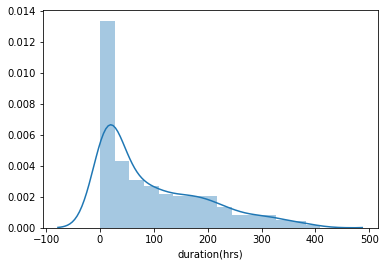

In [46]:
cd_dist = sns.distplot(caseTime['duration(hrs)'])

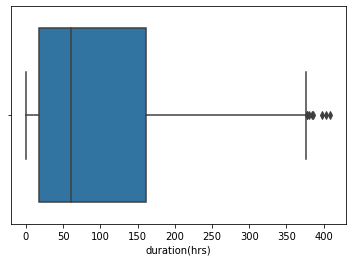

In [47]:
cd_box = sns.boxplot(x=caseTime['duration(hrs)'])

In [48]:
caseInfo['caseDuration'] = caseTime['duration(hrs)']

In [50]:
caseInfo.loc[:,'RepairOK']=caseInfo.loc[:,'RepairOK'].cat.add_categories("NotNeeded").fillna("NotNeeded")

AttributeError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


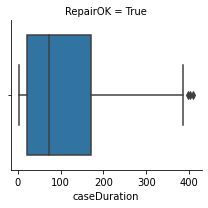

In [51]:
g = sns.FacetGrid(caseInfo, col="RepairOK")
g.map(sns.boxplot, "caseDuration")

In [52]:
# feature importance

In [53]:
t_repair[:40]

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
0,1,FirstContact,Dian,complete,1970-01-02 08:08:00,Phone,NaN,NaN,NaN,NaN,NaN,NaN
1,1,MakeTicket,Dian,start,1970-01-02 08:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,MakeTicket,Dian,complete,1970-01-02 08:11:00,NaN,E,1340.0,NaN,NaN,NaN,NaN
3,1,ArrangeSurvey,Dian,start,1970-01-02 08:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,ArrangeSurvey,Dian,complete,1970-01-02 08:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,InformClientSurvey,System,complete,1970-01-02 08:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,Survey,Cindy,start,1970-01-11 21:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Survey,Cindy,complete,1970-01-11 21:56:00,NaN,NaN,NaN,True,240.0,1.0,NaN
8,1,InternRepair,John,start,1970-01-17 04:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,InternRepair,John,complete,1970-01-17 08:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### event별 소요시간

In [54]:
#startTime = t_repair.loc[t_repair['eventtype']=='start','timestamp']
startIdx = t_repair.index[t_repair['eventtype']=='start']
startTime = t_repair.loc[startIdx,['caseID','taskID','eventtype','timestamp','originator']]
startTime

,caseID,taskID,eventtype,timestamp,originator
1,1,MakeTicket,start,1970-01-02 08:08:00,Dian
3,1,ArrangeSurvey,start,1970-01-02 08:11:00,Dian
6,1,Survey,start,1970-01-11 21:33:00,Cindy
8,1,InternRepair,start,1970-01-17 04:36:00,John
15,2,MakeTicket,start,1970-01-08 05:17:00,Dian
...,...,...,...,...,...
13243,999,ExternRepair,start,1970-01-07 05:11:00,DoIt
13249,1000,MakeTicket,start,1970-01-07 20:17:00,Monica
13251,1000,ArrangeSurvey,start,1970-01-07 20:21:00,Monica
13254,1000,Survey,start,1970-01-16 14:35:00,Cindy


In [55]:
endIdx = startIdx + 1
endTime = t_repair.loc[endIdx,['caseID','taskID','eventtype','timestamp','originator']]
endTime

,caseID,taskID,eventtype,timestamp,originator
2,1,MakeTicket,complete,1970-01-02 08:11:00,Dian
4,1,ArrangeSurvey,complete,1970-01-02 08:16:00,Dian
7,1,Survey,complete,1970-01-11 21:56:00,Cindy
9,1,InternRepair,complete,1970-01-17 08:12:00,John
16,2,MakeTicket,complete,1970-01-08 05:21:00,Dian
...,...,...,...,...,...
13244,999,RepairReady,complete,1970-01-07 12:23:00,System
13250,1000,MakeTicket,complete,1970-01-07 20:21:00,Monica
13252,1000,ArrangeSurvey,complete,1970-01-08 01:24:00,Dian
13255,1000,Survey,complete,1970-01-16 14:58:00,Cindy


In [56]:
# start, complete의 originator가 다를 수 있을까?
origS = startTime.reset_index(drop=True)
origE = endTime.reset_index(drop=True)
diffOrig = (origS.originator != origE.originator)

In [57]:
print(origS.loc[diffOrig,'taskID'].value_counts(dropna=False))
print(origE.loc[diffOrig,'taskID'].value_counts(dropna=False))

ExternRepair              132
ArrangeSurvey             123
TicketReady                 0
Survey                      0
SendTicketToFinAdmin        0
RepairReady                 0
ReadyInformClient           0
MakeTicket                  0
InternRepair                0
InformClientWrongPlace      0
InformClientSurvey          0
ImmediateRepair             0
FirstContact                0
Name: taskID, dtype: int64
RepairReady               132
ArrangeSurvey             123
TicketReady                 0
Survey                      0
SendTicketToFinAdmin        0
ReadyInformClient           0
MakeTicket                  0
InternRepair                0
InformClientWrongPlace      0
InformClientSurvey          0
ImmediateRepair             0
FirstContact                0
ExternRepair                0
Name: taskID, dtype: int64


In [58]:
diffOrigArr = (origS.originator != origE.originator) & (origS['taskID'] == 'ArrangeSurvey')
print(origS[diffOrigArr])
print(origE[diffOrigArr])
print(origE.loc[diffOrigArr,'originator'].value_counts())
diffOrigArrCaseIDs = origE.loc[diffOrigArr,'caseID']

      caseID         taskID eventtype           timestamp originator
30        10  ArrangeSurvey     start 1970-01-08 04:25:00     Monica
65        19  ArrangeSurvey     start 1970-01-07 01:47:00     Monica
77        22  ArrangeSurvey     start 1970-01-07 10:31:00     Monica
85        24  ArrangeSurvey     start 1970-01-07 05:46:00       Dian
101       28  ArrangeSurvey     start 1970-01-04 17:52:00       Dian
...      ...            ...       ...                 ...        ...
3771     983  ArrangeSurvey     start 1970-01-05 00:07:00       Dian
3775     984  ArrangeSurvey     start 1970-01-07 16:35:00       Dian
3779     985  ArrangeSurvey     start 1970-01-02 04:54:00       Dian
3808     992  ArrangeSurvey     start 1970-01-03 03:38:00       Dian
3840    1000  ArrangeSurvey     start 1970-01-07 20:21:00     Monica

[123 rows x 5 columns]
      caseID         taskID eventtype           timestamp originator
30        10  ArrangeSurvey  complete 1970-01-08 20:45:00       Dian
65        

caseID와 taskID가 동일하더라도 start와 complete의 originator 가 다를 수 있다.

In [59]:
eventDuration = endTime['timestamp'].reset_index(drop=True) - startTime['timestamp'].reset_index(drop=True)
#eventDuration
eventDuration_startIdx = eventDuration.rename(lambda x: startIdx[x]).astype('timedelta64[m]')

In [60]:
startTime['duration(min)'] = eventDuration_startIdx
eventDuration = startTime.drop(columns=['eventtype','timestamp']).reset_index(drop=True)
eventDuration

,caseID,taskID,originator,duration(min)
0,1,MakeTicket,Dian,3.0
1,1,ArrangeSurvey,Dian,5.0
2,1,Survey,Cindy,23.0
3,1,InternRepair,John,216.0
4,2,MakeTicket,Dian,4.0
...,...,...,...,...
3838,999,ExternRepair,DoIt,432.0
3839,1000,MakeTicket,Monica,4.0
3840,1000,ArrangeSurvey,Monica,303.0
3841,1000,Survey,Cindy,23.0


### Task별 소요시간

In [61]:
eventDuration.groupby(by="taskID")['duration(min)'].agg(["count","mean","std"])

,count,mean,std
taskID,,,
ArrangeSurvey,927,120.539374,280.939185
ExternRepair,132,298.757576,158.870158
FirstContact,0,NaN,NaN
ImmediateRepair,383,116.725849,16.246966
InformClientSurvey,0,NaN,NaN
InformClientWrongPlace,0,NaN,NaN
InternRepair,547,224.241316,37.350732
MakeTicket,927,4.445523,2.111625
ReadyInformClient,0,NaN,NaN


ArrangeSurvey와 ExternRepair의 표준편차가 크다. -> 서비스 불만족의 원인이 될 수 있다.

In [62]:
as_dur = eventDuration.loc[eventDuration['taskID']=="ArrangeSurvey",'duration(min)']

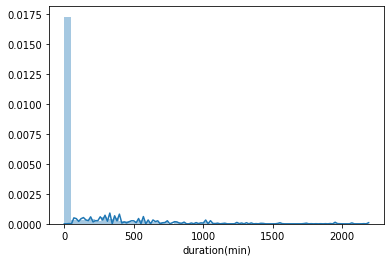

In [63]:
as_dur_dist = sns.distplot(as_dur)

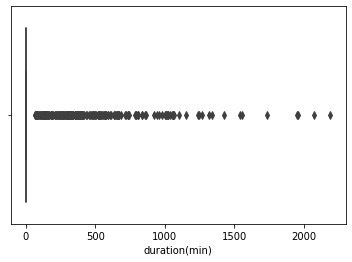

In [64]:
as_box = sns.boxplot(x=as_dur)

In [65]:
as_dur.quantile(.85)

303.0

In [93]:
as_dur.describe()

count     927.000000
mean      120.539374
std       280.939185
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max      2189.000000
Name: duration(min), dtype: float64

AttributeError: ignored

In [66]:
asDurOutlierFilt = (eventDuration['taskID']=="ArrangeSurvey") & (eventDuration['duration(min)']> 303)
asDurOutlierCaseID = eventDuration.loc[asDurOutlierFilt,'caseID']


In [67]:
t_repair[(t_repair['caseID'].isin(asDurOutlierCaseID)) & (t_repair['taskID']=="ArrangeSurvey")]

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
106,10,ArrangeSurvey,Monica,start,1970-01-08 04:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,10,ArrangeSurvey,Dian,complete,1970-01-08 20:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,16,ArrangeSurvey,Dian,start,1970-01-08 03:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,16,ArrangeSurvey,Dian,complete,1970-01-08 14:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,24,ArrangeSurvey,Dian,start,1970-01-07 05:46:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12972,980,ArrangeSurvey,Dian,complete,1970-01-07 05:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13028,984,ArrangeSurvey,Dian,start,1970-01-07 16:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13029,984,ArrangeSurvey,Monica,complete,1970-01-08 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13042,985,ArrangeSurvey,Dian,start,1970-01-02 04:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
t_repair.loc[(t_repair['caseID'].isin(asDurOutlierCaseID)) & (t_repair['taskID']=="ArrangeSurvey"),'originator'].value_counts()

Monica    154
Dian      122
Name: originator, dtype: int64

In [69]:
t_repair.loc[(t_repair['caseID'].isin(asDurOutlierCaseID)) & (t_repair['taskID']=="ArrangeSurvey")&(t_repair['originator']=='Monica'),'eventtype'].value_counts()

start       78
complete    76
Name: eventtype, dtype: int64

In [70]:
er_dur = eventDuration.loc[eventDuration['taskID']=="ExternRepair",'duration(min)']

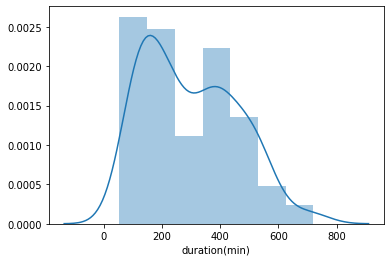

In [71]:
er_dur_dist = sns.distplot(er_dur)

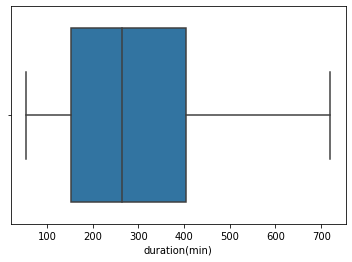

In [72]:
er_box = sns.boxplot(x=er_dur)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


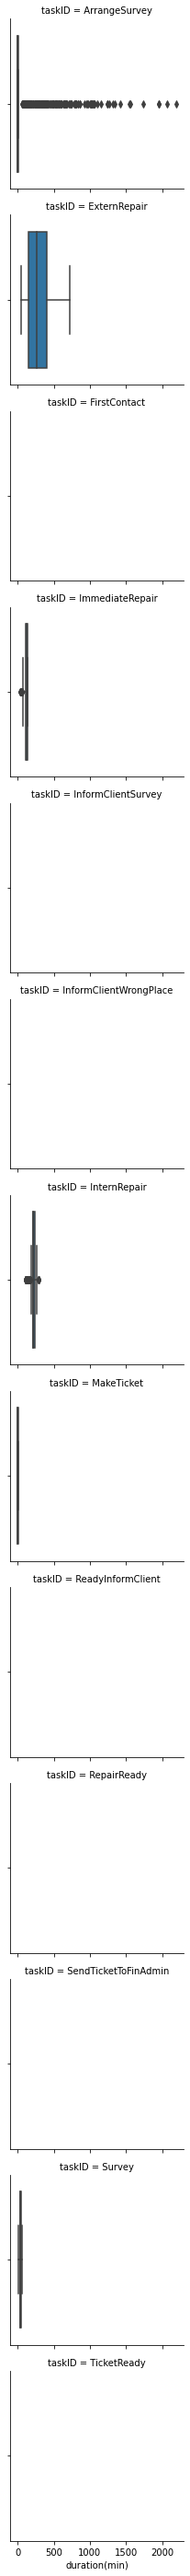

In [73]:
g = sns.FacetGrid(eventDuration, row="taskID")
g.map(sns.boxplot, "duration(min)")

[Text(0, 0, 'ArrangeSurvey'),
 Text(0, 0, 'ExternRepair'),
 Text(0, 0, 'FirstContact'),
 Text(0, 0, 'ImmediateRepair'),
 Text(0, 0, 'InformClientSurvey'),
 Text(0, 0, 'InformClientWrongPlace'),
 Text(0, 0, 'InternRepair'),
 Text(0, 0, 'MakeTicket'),
 Text(0, 0, 'ReadyInformClient'),
 Text(0, 0, 'RepairReady'),
 Text(0, 0, 'SendTicketToFinAdmin'),
 Text(0, 0, 'Survey'),
 Text(0, 0, 'TicketReady')]

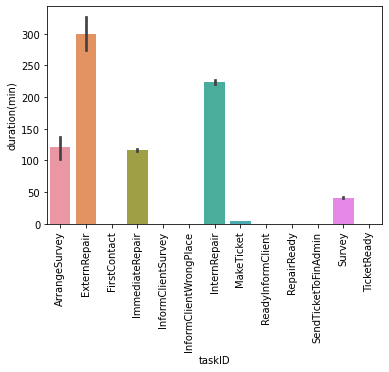

In [74]:
axTaskDur = sns.barplot(x="taskID", y="duration(min)", data=eventDuration)
axTaskDur.set_xticklabels(axTaskDur.get_xticklabels(), rotation=90)

### originator별 소요시간

In [76]:
eventDuration.groupby(by="originator")['duration(min)'].agg(["count","mean","std"])

,count,mean,std
originator,,,
Anne,433,87.697460,50.521937
Barbara,214,88.308411,52.912437
Ben,60,88.633333,83.849536
Cindy,194,139.242268,99.075928
Dian,874,62.491991,212.936014
DoIt,66,278.303030,139.392635
Edd,186,145.516129,98.057800
Eric,49,103.877551,86.507618
FixIt,66,319.212121,174.893683


[Text(0, 0, 'Dian'),
 Text(0, 0, 'Cindy'),
 Text(0, 0, 'John'),
 Text(0, 0, 'Anne'),
 Text(0, 0, 'DoIt'),
 Text(0, 0, 'Paul'),
 Text(0, 0, 'Monica'),
 Text(0, 0, 'Jacky'),
 Text(0, 0, 'Edd'),
 Text(0, 0, 'Barbara'),
 Text(0, 0, 'Eric'),
 Text(0, 0, 'FixIt'),
 Text(0, 0, 'Nick'),
 Text(0, 0, 'Lex'),
 Text(0, 0, 'Ben')]

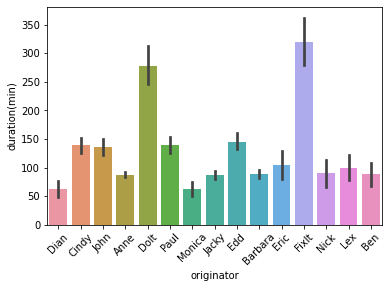

In [77]:
axOriDur = sns.barplot(x="originator", y="duration(min)", data=eventDuration)
axOriDur.set_xticklabels(axOriDur.get_xticklabels(), rotation=45)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


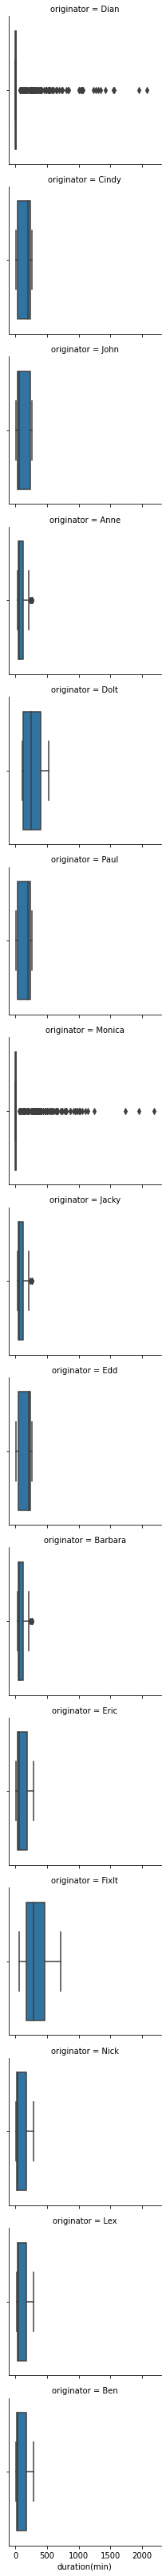

In [78]:
gTask = sns.FacetGrid(eventDuration, row="originator")
gTask.map(sns.boxplot, "duration(min)")

### 예상수리소요시간 v. 실제수리소요시간

In [79]:
# 실제수리소요시간 -> t(RepairReady) - r(surv_cmpltd.next) 
tRepairReady = t_repair.loc[t_repair['taskID']=="RepairReady","timestamp"].reset_index(drop=True)
#print(tRepairReady)
surComIdx = t_repair.index[(t_repair['taskID']=="Survey") & (t_repair['eventtype']=="complete")]
startRepairIdx = surComIdx + 1
#print(t_repair.loc[startRepairIdx,["caseID","taskID","eventtype"]])
tRepairStart = t_repair.loc[startRepairIdx,'timestamp'].reset_index(drop=True)
# difference with caseID
repairCases = t_repair.loc[t_repair['taskID']=="RepairReady","caseID"].reset_index(drop=True)
repairDur = (tRepairReady - tRepairStart).astype('timedelta64[m]')
repairAct = pd.DataFrame(data={'caseID':repairCases,'repairDur':repairDur})
repairAct.info()
# join with case relation
#caseInfo.merge(repairAct,on='caseID',how='left')
caseInfo.loc[repairAct['caseID'],'repairDur'] = repairAct['repairDur'].array
caseInfo


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   caseID     927 non-null    int64  
 1   repairDur  927 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 14.6 KB


,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK,caseDuration,repairDur
1,Phone,E,1340,True,240,1,True,367.0,216.0
2,Personal,P,8161,True,120,1,True,105.0,240.0
3,Phone,E,3844,True,220,2,True,102.0,220.0
4,Personal,P,6582,True,120,1,True,39.0,120.0
5,Letter,P,9857,True,120,1,True,57.0,108.0
...,...,...,...,...,...,...,...,...,...
996,Phone,E,1851,True,220,2,True,23.0,220.0
997,Phone,E,3807,True,240,1,True,199.0,264.0
998,Personal,E,2142,True,220,2,True,300.0,220.0
999,Personal,B,3598,False,480,4,True,11.0,432.0


In [80]:
caseInfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   contact              1000 non-null   object 
 1   RepairType           927 non-null    object 
 2   objectKey            927 non-null    object 
 3   RepairInternally     927 non-null    object 
 4   EstimatedRepairTime  927 non-null    object 
 5   RepairCode           927 non-null    object 
 6   RepairOK             927 non-null    object 
 7   caseDuration         1000 non-null   float64
 8   repairDur            927 non-null    float64
dtypes: float64(2), object(7)
memory usage: 118.1+ KB


In [81]:
caseInfo['EstimatedRepairTime'].astype('float64')
diff = (caseInfo['EstimatedRepairTime'] - caseInfo['repairDur']).astype('float64').abs()
diff

1        24.0
2       120.0
3         0.0
4         0.0
5        12.0
        ...  
996       0.0
997      24.0
998       0.0
999      48.0
1000      0.0
Length: 1000, dtype: float64

In [82]:
diff.isna().sum()

73

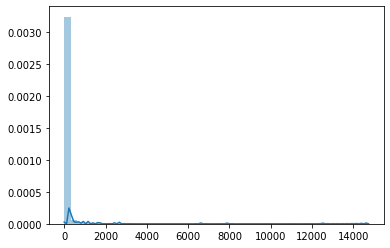

In [83]:
ax = sns.distplot(diff)

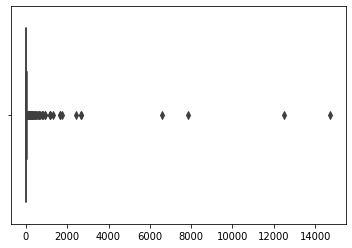

In [84]:
ax2 = sns.boxplot(x=diff)

In [85]:
diff.describe()

count      927.000000
mean       108.979504
std        744.702418
min          0.000000
25%          0.000000
50%         16.000000
75%         24.000000
max      14736.000000
dtype: float64

In [86]:
diffOutliers = diff[~diff.between(diff.quantile(.15),diff.quantile(.85)) & ~diff.isna()]
diffOutliersCaseIDs = diffOutliers.index

In [87]:
t_repair[t_repair['caseID'].isin(diffOutliersCaseIDs)]

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
14,2,FirstContact,Dian,complete,1970-01-08 05:17:00,Personal,NaN,NaN,NaN,NaN,NaN,NaN
15,2,MakeTicket,Dian,start,1970-01-08 05:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2,MakeTicket,Dian,complete,1970-01-08 05:21:00,NaN,P,8161.0,NaN,NaN,NaN,NaN
17,2,ArrangeSurvey,Dian,start,1970-01-08 05:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2,ArrangeSurvey,Dian,complete,1970-01-08 05:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12992,981,ExternRepair,FixIt,start,1970-01-02 12:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12993,981,RepairReady,System,complete,1970-01-02 15:28:00,NaN,NaN,NaN,NaN,NaN,NaN,True
12994,981,SendTicketToFinAdmin,System,complete,1970-01-02 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12995,981,ReadyInformClient,System,complete,1970-01-02 19:10:00,NaN,NaN,NaN,NaN,NaN,NaN,True


In [88]:
t_repair.loc[t_repair['caseID'].isin(diffOutliersCaseIDs) & (t_repair['taskID']=="ArrangeSurvey"),'originator'].value_counts()

Monica    137
Dian      125
Name: originator, dtype: int64

## 문제해결

여태까지 있었던 outlierCaseID들 교집합 구하기
Monica만 있으면 문제인가?
Dian만 있으면 문제인가?
둘이 같이 있을 때만 문제인가?
왜 둘이 있으면 문제인가? 

In [89]:
print(len(diffOutliersCaseIDs))
print(len(diffOrigArrCaseIDs))
print(len(asDurOutlierCaseID))

131
123
138


In [90]:
diffOrigArrCaseIDs.isin(asDurOutlierCaseID).value_counts()

True     70
False    53
Name: caseID, dtype: int64

In [91]:
asDurOutlierCaseID.isin(diffOrigArrCaseIDs).value_counts()

True     70
False    68
Name: caseID, dtype: int64

In [92]:
asDurOutlierCaseID.isin(diffOutliersCaseIDs).value_counts()

False    124
True      14
Name: caseID, dtype: int64